# Import Libraries

In [ ]:
# Import the necessary python libraries.
import tensorflow as tf
import numpy as np
import random

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, Lambda
from tensorflow.keras.layers import Conv2D, Activation,AveragePooling2D
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import backend as K

import os
from tqdm import tqdm
from PIL import Image

In [ ]:
IMAGE_SIZE = 128

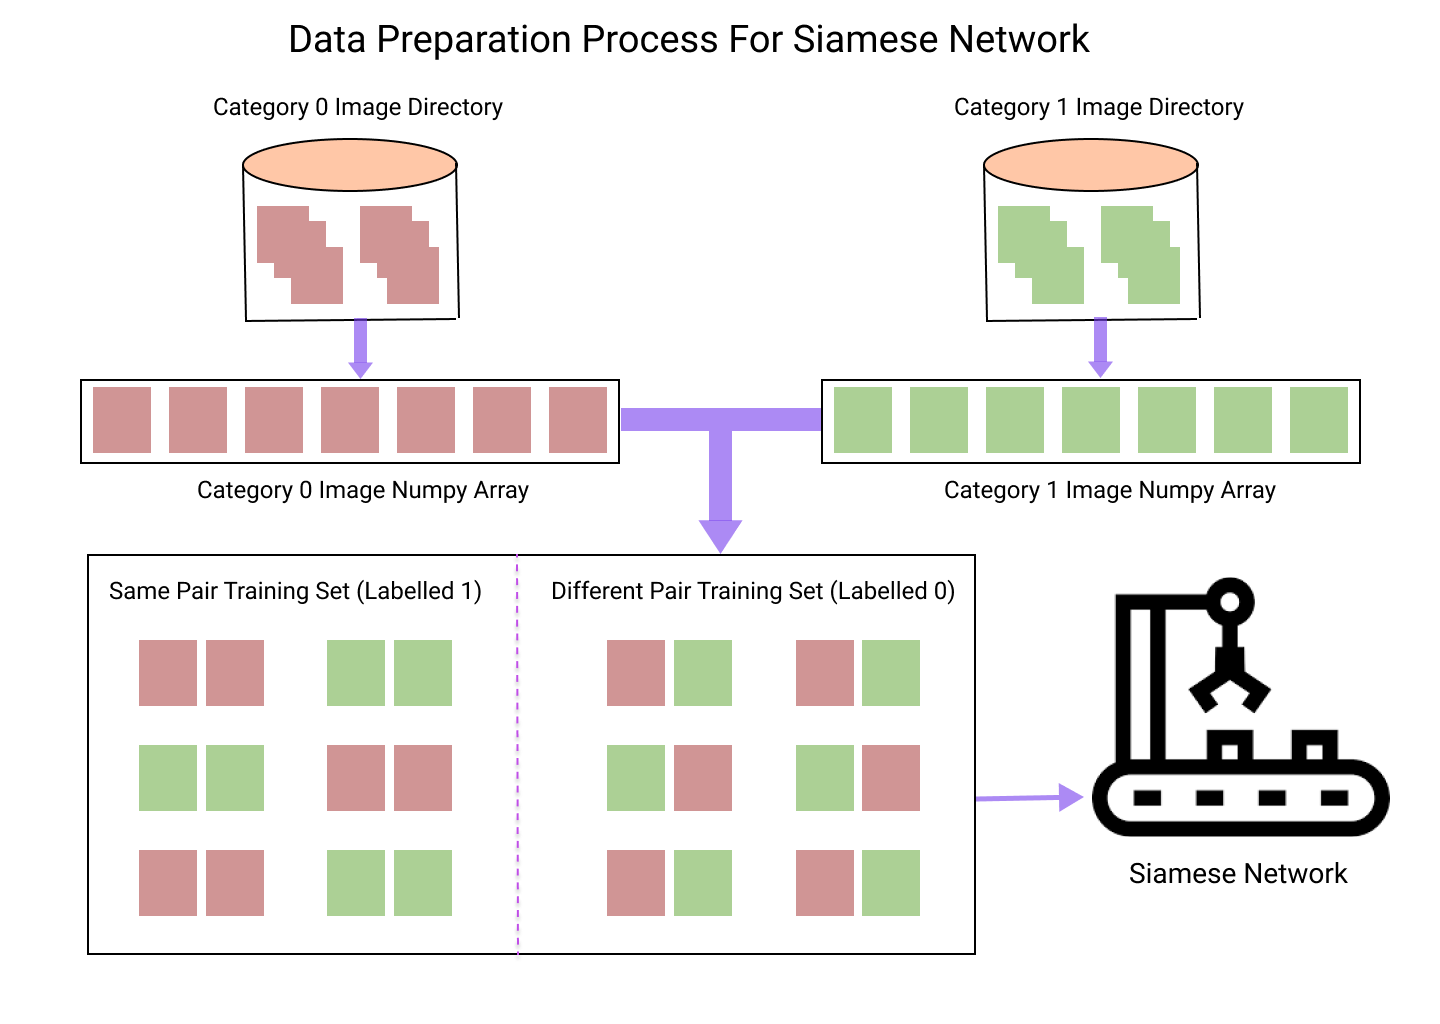

# Prepare Data

In [ ]:
class Data_Prep():
  '''
  Class that prepares the custom input data for the neural network.
  '''

  def __init__(self, seed = 77, img_size = 128, data_dir = '/content/drive/MyDrive/data_folder', sample_size = 2000):
    '''
    Init Data_Prep

    Args:
      seed::[int]
      Set the seed for reproducibility of code. Default: 77.

      img_size::[int]
      Input image dimension. Default: 128.

      data_dir::[str]
      Directory that contains the data.

      sample_size::[int]
      The number of samples for training set. 
      Limit is the max number of training images. Default: 2000
    '''
    self.data_dir = data_dir

    # Best practice, for random number generator seed settings.
    self.rng = np.random.default_rng(seed)

    self.img_size = img_size

    self.sample_size = sample_size


  def read_image_array(self, sub_dir, sample_size = None, shuffle = False):
    '''
    Read the images from directory.

    Args:
      
      sub_dir::[str]
      Name of the sub folder within base directory that contains the 
      the images.

      sample_size::[int]
      Number of images to read.

      shuffle::[bool]
      Param to indicate shuffling of data.

    Return::[np.array]:
      Return numpy array of all images.

    '''
    # The full path
    full_path = os.path.join(self.data_dir, sub_dir)
    
    # The image file names at path
    image_list = os.listdir(full_path)

    # Number of total images in image list
    n_img = len(image_list)

    # Whether to shuffle the data.
    if shuffle:
      
      self.rng.shuffle(image_list)

    if sample_size:

      # restrict the sample size to be smaller than the number
      # of images in image_list. 
      if sample_size > n_img:

        raise('Cannot sample images more than the number in set')

      # Select a smaller sample.
      image_list = image_list[:sample_size]

    # Store result in this list.
    image_read_res = []

    print(f'Starting to read {sub_dir} images')

    # For loop to read the images, and resizing them in the process.
    for i in tqdm(image_list):
      
      image_read_res.append(np.asarray(Image.open(f"{full_path}/{i}").resize((self.img_size, self.img_size), Image.ANTIALIAS)))

    # Return numpy array
    return np.array(image_read_res)

  def read_data(self):
    '''
    Driver code to read in input images from multiple source.

    Args:
      None
    
    Returns:
      None
    '''

    # Category 1 images that contain mantaray images.
    image_1 = self.read_image_array('train2020', self.sample_size, True)

    # Category 0 images that contain segmentated background images.
    image_0_tl = self.read_image_array('top_left', self.sample_size // 4, True)
    image_0_tr = self.read_image_array('top_right', self.sample_size // 4, True)
    image_0_bl = self.read_image_array('bottom_left', self.sample_size // 4, True)
    image_0_br = self.read_image_array('bottom_right', self.sample_size // 4, True)

    # Bring together the four corners.
    image_0 = np.concatenate([image_0_tl, image_0_tr, image_0_bl, image_0_br], axis=0)

    # Useful info.
    print(f'Image category 1 shape {image_1.shape} & size {(image_1.size * image_1.itemsize) / 1000000} MB')

    print(f'Image category 0 shape {image_0.shape} & size {(image_0.size * image_0.itemsize) / 1000000} MB')

    # Both category images together form the training set.
    X_train = np.concatenate([image_0, image_1], axis=0)

    # Create category label.
    y_train = [0] * image_0.shape[0] + [1] * image_1.shape[0]

    # Normalize the image values.
    X_train = X_train / 255

    # Covert to float32
    X_train = X_train.astype('float32')

    # Useful info
    print(f'X_train shape {X_train.shape} & size {(X_train.size * X_train.itemsize) / 1000000} MB')
    print(f'y_train shape {len(y_train)}')

    # Raise error if the shape is not the same.
    assert len(X_train) == len(y_train)

    # Shuffle the data in pairs.
    p = self.rng.permutation(len(X_train))

    # X_train, y_train
    self.X_train, self.y_train = X_train[p], np.array(y_train)[p]

    # Set the number of classes
    self.num_classes = len(np.unique(y_train))
    

  def create_pairs(self, x, class_indices):
    '''
    Function that creates Siamese network input pairs and labels. Here the 
    objective is to create matching pairs marked as label 1 and non-matching 
    pairs marked as label 0.

    Args:
      x::[np.array]
      The image numpy array data.
      
      class_indices::[np.array]
      An array containing an array for each category, indicating the image
      position within array.

    Returns:
      Pairs and labels.
    '''

    print('Started creating pairs ...')

    # Training pairs
    training_pairs = []
    
    # Labels. If same class image then 1, or else 0.
    labels = []

    # Since, each category has variable images, take the minimum to avoid
    # list range problem.
    n = min( [len(class_indices[c]) for c in range(self.num_classes)] ) - 1

    # For each class
    for d in range(self.num_classes):

      # For each sample
      for i in range(n):

        # Form pairs with current and next image in same class.
        i1, i2 = class_indices[d][i], class_indices[d][i+1]
        
        # Add this image pair to training set.
        training_pairs += [[x[i1], x[i2]]]
        
        # Randomly add a number from 1 to num_class to current class.
        # Shift the base as class starts with 0.
        inc = random.randrange(1, self.num_classes)
        dn = (d + inc) % self.num_classes

        # Add training pair from different classes.
        # That is our class 0.
        i1, i2 = class_indices[d][i], class_indices[dn][i]
        training_pairs += [[x[i1], x[i2]]]

        # Add labels
        labels += [1,0]

    print('Finished creating pairs & labels. :)')
        
    return np.array(training_pairs), np.array(labels)

  def __call__(self):
    '''
    Main driver code to call all the above functions to read in training data.

    Returns:
      Training pairs and labels.
    '''
    self.read_data()

    self.digit_indices = [np.where(self.y_train == i)[0] for i in range(self.num_classes)]

    return self.create_pairs(self.X_train, self.digit_indices)

In [ ]:
dpin = Data_Prep(img_size = IMAGE_SIZE, sample_size=1200)

In [ ]:
dp_output = dpin()

Starting to read train2020 images


100%|██████████| 1200/1200 [03:32<00:00,  5.64it/s]


Starting to read top_left images


100%|██████████| 300/300 [00:53<00:00,  5.59it/s] 


Starting to read top_right images


100%|██████████| 300/300 [00:50<00:00,  5.89it/s] 


Starting to read bottom_left images


100%|██████████| 300/300 [00:50<00:00,  5.90it/s] 


Starting to read bottom_right images


100%|██████████| 300/300 [00:53<00:00,  5.62it/s] 


Image category 1 shape (1200, 128, 128, 3) & size 58.9824 MB
Image category 0 shape (1200, 128, 128, 3) & size 58.9824 MB
X_train shape (2400, 128, 128, 3) & size 471.8592 MB
y_train shape 2400
Started creating pairs ...
Finished creating pairs & labels. :)


## Siamese Network Architecture

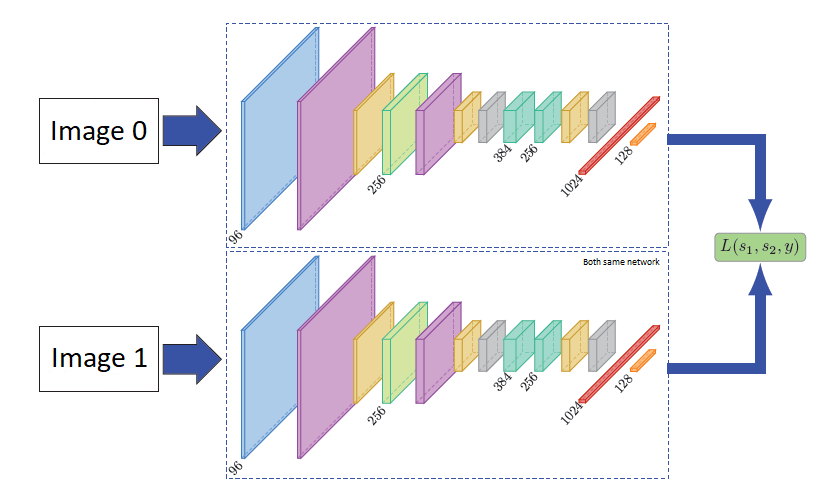

# Custom Loss Function

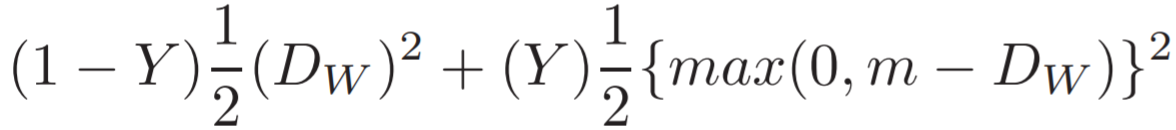

In [ ]:
# Implementation of the Contrastive Loss.
# Theory Explanation.
# http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf

from tensorflow import keras
class CustomCL(keras.losses.Loss):
  def __init__(self, margin = 1, name="custom_cl"):
    super().__init__(name=name)

    # Margin is the hyperparameter.
    self.margin = margin

  def call(self, y_true, y_pred):
    
    # Convert from int to float.
    y_pred = tf.cast(y_pred, tf.float32)
    y_true = tf.cast(y_true, tf.float32)

    # Apply the formula.
    d_w2 = K.square(y_pred)
    margin_d_w2 = K.square(K.maximum(self.margin - y_pred, 0))
    total_loss =  K.mean(y_true * d_w2 + (1 - y_true) * margin_d_w2)
    return total_loss

In [ ]:
def compute_acc(y_true, y_pred):
  '''Compute classification accuracy with a fixed threshold on distances.
  '''
  pred = y_pred.ravel() < 0.5
  return np.mean(pred == y_true)

In [ ]:
def custom_acc(y_true, y_pred):

    # Binarize the prediction into class 1 or 0.
    bin_class = K.cast(y_pred < 0.5, y_true.dtype)
    
    # Check if pred = true. 1 for yes, 0 for no.
    check_eq = K.equal(y_true, bin_class)

    # Return number of correctly predicted cases as accuracy
    return K.mean(check_eq)

# Siamese Network Builder

In [ ]:
class Siamese_Model():
  '''
  Build the Siamese Model.
  '''
  def __init__(self, num_classes = 2, input_shape = (128, 128, 3)):
    ''' 
    Initialize the model.

    Args:
      num_classes::[int]
      Number of unique categories. 

      input_shape::[tuple]
      Input Image Shape.
    '''
    
    self.NUM_CLASSES = num_classes
    self.INPUT_SHAPE = input_shape


  @staticmethod
  def euclidean_distance(input):
    '''
    Utility function to calculate the Euclidean distance.

    Args:
      input::[tuple]
      Input vectors.

    Returns:
      Euclidean distance between vectors.
    '''
    v1, v2 = input
    ss = K.sum(K.square(v1 - v2), axis=1, keepdims=True)
    return K.sqrt(K.maximum(ss, K.epsilon()))

  def bn(self, print_summary = False):
    '''
    Base Convolution Siamese Network. This architecture is under study.

    Args:
      print_summary::[bool]
      For development check model architecture.

    Returns:
      Base model.
    '''

    input = Input(shape = self.INPUT_SHAPE)
    x = Conv2D(4, (5,5), activation = 'tanh')(input)
    x = AveragePooling2D(pool_size = (2,2))(x)
    x = Conv2D(16, (5,5), activation = 'tanh')(x)
    x = AveragePooling2D(pool_size = (2,2))(x)
    x = Flatten()(x)
    x = Dense(128, activation = 'relu')(x)
    x = Lambda(lambda  x: K.l2_normalize(x,axis=1))(x)
    model = Model(input, x)
    
    if print_summary:
      model.summary()
    
    return model

  def bn1(self, print_summary = False):
    '''
    Base Fully Connected Siamese Network. Works well.

    Args:
      print_summary::[bool]
      For development check model architecture.

    Returns:
      Base model.
    '''
    input = Input(shape = self.INPUT_SHAPE)
    x = Flatten()(input)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.1)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.1)(x)
    x = Dense(128, activation='relu')(x)
    x = Lambda(lambda  x: K.l2_normalize(x,axis=1))(x)
    model = Model(input, x)
    
    if print_summary:
      model.summary()
    
    return model


  def __call__(self):
    '''
    Create model.
    '''
    # bn is under study
    # bnet = self.bn()

    # Working bn1 architecture. This is a fully connected network.
    bnet = self.bn1()

    # Two inputs.
    input_left = Input(shape=self.INPUT_SHAPE)
    input_right = Input(shape=self.INPUT_SHAPE)

    # Output of base networks.
    out_left = bnet(input_left)
    out_right = bnet(input_right)

    # Euclidean distance of 128 length output vectors.
    distance = Lambda(Siamese_Model.euclidean_distance,
                      output_shape=(1,1))([out_left, out_right])

    # Construct final model.
    model = Model([input_left, input_right], distance)

    return model

# Train the model

In [ ]:
class TrainLoop():
  '''
  Training Process Handler.
  '''
  def __init__(self, epochs, batch_size, optimizer, tr_pairs, tr_y):
    '''
    Initialize the training params.

    Args:
      epochs::[int]
      The number of epochs to train the model.

      batch_size::[int]
      The number of images in a batch.

      optimizer::[object]
      Keras optimizer object.

      tr_pairs::[numpy.ndarray]
      Training Image Pairs.

      ty_y::[numpy.array]
      Training labels.
    '''
    self.EPOCHS = epochs
    self.OPTIMIZER = optimizer
    self.BATCH_SIZE = batch_size
    self.tr_pairs = tr_pairs
    self.tr_y = tr_y
    

  def __call__(self):
    '''
    Compile and train the model.
    '''

    # Initialize the model object.
    sm_obj = Siamese_Model()

    # Call the model.
    sm = sm_obj()

    # Compile the model.
    sm.compile(optimizer = self.OPTIMIZER, loss = CustomCL(), metrics = [custom_acc])

    print('Compiled model. Starting training process.')

    history = sm.fit([self.tr_pairs[:, 0], self.tr_pairs[:, 1]], self.tr_y,
          batch_size=self.BATCH_SIZE,
          epochs=self.EPOCHS)
    
    print('Finished training.')
    
    return sm, history


In [ ]:
# Train Model.
train_obj = TrainLoop(100, 128, RMSprop(), dp_output[0], dp_output[1])

In [ ]:
result = train_obj()

Compiled model. Starting training process.
Epoch 1/100
38/38 [==============================] - 3s 38ms/step - loss: 0.2600 - custom_acc: 0.5010
Epoch 2/100
38/38 [==============================] - 1s 37ms/step - loss: 0.2597 - custom_acc: 0.4910
Epoch 3/100
38/38 [==============================] - 1s 38ms/step - loss: 0.2571 - custom_acc: 0.5007
Epoch 4/100
38/38 [==============================] - 1s 37ms/step - loss: 0.2577 - custom_acc: 0.4900
Epoch 5/100
38/38 [==============================] - 1s 38ms/step - loss: 0.2547 - custom_acc: 0.5189
Epoch 6/100
38/38 [==============================] - 1s 37ms/step - loss: 0.2539 - custom_acc: 0.5145
Epoch 7/100
38/38 [==============================] - 1s 38ms/step - loss: 0.2541 - custom_acc: 0.5177
Epoch 8/100
38/38 [==============================] - 1s 38ms/step - loss: 0.2499 - custom_acc: 0.5389
Epoch 9/100
38/38 [==============================] - 1s 38ms/step - loss: 0.2460 - custom_acc: 0.5700
Epoch 10/100
38/38 [===================

In [ ]:
%whos

Variable           Type         Data/Info
-----------------------------------------
Activation         type         <class 'keras.layers.core.activation.Activation'>
AveragePooling2D   type         <class 'keras.layers.pooling.AveragePooling2D'>
Conv2D             type         <class 'keras.layers.convolutional.Conv2D'>
CustomCL           type         <class '__main__.CustomCL'>
Dense              type         <class 'keras.layers.core.dense.Dense'>
Dropout            type         <class 'keras.layers.core.dropout.Dropout'>
Flatten            type         <class 'keras.layers.core.flatten.Flatten'>
Image              module       <module 'PIL.Image' from <...>t-packages/PIL/Image.py'>
Input              function     <function Input at 0x7f266b406440>
K                  module       <module 'keras.api._v2.ke<...>ras/backend/__init__.py'>
Lambda             type         <class 'keras.layers.core.lambda_layer.Lambda'>
Model              type         <class 'keras.engine.training.Model'>
R

Leaky memory problem. Predict function execution causes RAM to increase beyond capacity causing session to crash. https://github.com/keras-team/keras/issues/13118

# Prediction result.

In [ ]:
# K. clear_session()
# from numba import cuda
# cuda.select_device(0)
# cuda.close()

In [ ]:
# Predict Training samples with trained model.
y_tr_pred = result[0].predict([dp_output[0][:,0], dp_output[0][:,1]])

In [ ]:
# Prediction shape.
print(f'Computed prediction on training set. {y_tr_pred.shape}')

Computed prediction on training set. (4796, 1)


In [ ]:
# Training final accuracy
training_accuracy = compute_acc(dp_output[1], y_tr_pred)

In [ ]:
# Training accuracy.
print('Accuracy on training set: %0.2f%%' % (100 * training_accuracy))

Accuracy on training set: 88.43%


# To-Do
- Create prediction on test set.
- Demo original use case of classifying a directory to extract background images, from mantaray images.
- Use the trained model output vector to perform clustering. This will form basis to cluster different mantaray images, and to understand the unique feature of these fish.

# Reference
- https://medium.com/@maksym.bekuzarov/losses-explained-contrastive-loss-f8f57fe32246

## Extended data preparation

In [ ]:
# import os
# len(os.listdir('/content/drive/MyDrive/data_folder/train2020'))

2839

In [ ]:
# from random import sample
# bl = sample(os.listdir('/content/drive/MyDrive/data_folder/bottom_left'), 100)
# br = sample(os.listdir('/content/drive/MyDrive/data_folder/bottom_right'), 100)
# tl = sample(os.listdir('/content/drive/MyDrive/data_folder/top_left'), 100)
# tr = sample(os.listdir('/content/drive/MyDrive/data_folder/top_right'), 100)

In [ ]:
# import os, shutil
# path = "/content/drive/MyDrive/data_folder/train2020"
# moveto = "/content/drive/MyDrive/data_folder/test"
# for f in bl:
#     src = os.path.join(path,f)
#     dst = os.path.join(moveto, 'manta_'+f)
#     shutil.move(src,dst)

In [ ]:
# import os
# test_image_list = os.listdir('/content/drive/MyDrive/data_folder/test')

In [ ]:
# import pandas as pd
# test_label = pd.Series(test_image_list).apply(lambda x: 0 if 'back' in x else 1) 

In [ ]:
# test_image_list = [os.path.join('/content/drive/MyDrive/data_folder/test',i) for i in test_image_list]

In [ ]:
# test_csv = pd.DataFrame({'test_image_path': test_image_list, 'test_label': test_label})

In [ ]:
# test_csv.tail()

,test_image_path,test_label
795,/content/drive/MyDrive/data_folder/test/back_0...,0
796,/content/drive/MyDrive/data_folder/test/back_0...,0
797,/content/drive/MyDrive/data_folder/test/back_0...,0
798,/content/drive/MyDrive/data_folder/test/back_0...,0
799,/content/drive/MyDrive/data_folder/test/back_0...,0


In [ ]:
# Here 0 is mantaray images and 1 is no fish or just background.

In [ ]:
# test_csv.to_csv('/content/drive/MyDrive/data_folder/test_info.csv')

In [ ]:
# import pandas as pd
# import numpy as np
# from tqdm import tqdm
# tqdm.pandas()

In [ ]:
# Let's create test pairs
# First read in the images into an array
# X_test = test_csv.test_image_path.progress_apply(lambda x: np.asarray(Image.open(x).resize((IMAGE_SIZE, IMAGE_SIZE), Image.ANTIALIAS)))

100%|██████████| 800/800 [07:45<00:00,  1.72it/s]


In [ ]:
# X_test = np.concatenate(X_test).reshape(X_test.shape[0],128,128,3)

In [ ]:
# X_test = X_test / 255

In [ ]:
# y_test = np.array(test_csv['test_label'])

In [ ]:
# assert len(X_test) == len(y_test)

In [ ]:
# p = np.random.default_rng(77).permutation(len(X_test))

In [ ]:
# X_test, y_test = X_test[p], y_test[p]

In [ ]:
# num_classes = len(np.unique(y_test))

In [ ]:
# num_classes

2

In [ ]:
# digit_indices = [np.where(y_test == i)[0] for i in range(num_classes)]

In [ ]:
# def create_pairs(x, class_indices):
#     '''
#     Function that creates Siamese network input pairs and labels. Here the 
#     objective is to create matching pairs marked as label 1 and non-matching 
#     pairs marked as label 0.

#     Args:
#       x::[np.array]
#       The image numpy array data.
      
#       class_indices::[np.array]
#       An array containing an array for each category, indicating the image
#       position within array.

#     Returns:
#       Pairs and labels.
#     '''

#     print('Started creating pairs ...')

#     # Pairs
#     pairs = []
    
#     # Labels. If same class image then 1, or else 0.
#     labels = []

#     # Since, each category has variable images, take the minimum to avoid
#     # list range problem.
#     n = min( [len(class_indices[c]) for c in range(num_classes)] ) - 1

#     # For each class
#     for d in range(num_classes):

#       # For each sample
#       for i in range(n):

#         # Form pairs with current and next image in same class.
#         i1, i2 = class_indices[d][i], class_indices[d][i+1]
        
#         # Add this image pair to training set.
#         pairs += [[x[i1], x[i2]]]
        
#         # Randomly add a number from 1 to num_class to current class.
#         # Shift the base as class starts with 0.
#         inc = random.randrange(1, num_classes)
#         dn = (d + inc) % num_classes

#         # Add training pair from different classes.
#         # That is our class 0.
#         i1, i2 = class_indices[d][i], class_indices[dn][i]
#         pairs += [[x[i1], x[i2]]]

#         # Add labels
#         labels += [1,0]

#     print('Finished creating pairs & labels. :)')
        
#     return np.array(pairs), np.array(labels)

In [ ]:
# x_output = create_pairs(X_test, digit_indices)

Started creating pairs ...
Finished creating pairs & labels. :)


In [ ]:
# x_output[0][:,0].shape

(1596, 128, 128, 3)

In [ ]:
# x_output[1]

array([1, 0, 1, ..., 0, 1, 0])

In [ ]:
# np.save('x_test_array.npy', x_output[0])

In [ ]:
# np.save('/content/drive/MyDrive/data_folder/x_test_label.npy', x_output[1])

In [ ]:
import numpy as np
with open('/content/drive/MyDrive/data_folder/x_test_array.npy', 'rb') as f:
  x_test_array = np.load(f)

In [ ]:
with open('/content/drive/MyDrive/data_folder/x_test_label.npy', 'rb') as f:
  x_test_label = np.load(f)